# Approach 2: Emperical Bayes shrinkage of OBP

In this notebook we are going to treat OBP similar to BA, in that we will count instances of on-base and no-base. For batting averages, the number of ABs signficant impacts the true BA, where a batter with a total 5 hits in 10 ABs has a better carreer batting average than say, Hank Aaron... We know that the true BA lives around .250 across all batters. We will do the same with OBP to see if simply by correcting for our observed OBP with shrinkage, we can get a better estimate of end-of-season OBP. Note that the first part of this will not consider and ML. At most, we can use regression to make a simple estimate. 


## Import modules

In [1]:
import numpy as np
import pandas as pd
import pybaseball
import scipy.stats as stats
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"

# Define colors
phillies_red  = np.divide((232, 24, 40),255)
phillies_blue = np.divide((0, 45, 114),255)



Here we are relying on the Lahman database to get the historical data used for estimating the parameters of our model. 

In [41]:
from pybaseball.lahman import batting
from pybaseball.lahman import pitching

# Get the data
batting_data = batting()
pitching_data = pitching()

# Remove unneeded columns
rows_to_keep = (batting_data.AB > 0) & (batting_data.yearID < 2019) #& (batting_data.lgID == "NL") 
cols_to_keep = ["AB","H","BB","HBP","SF","HR","playerID","yearID"]

# Add the player's name for ease of reading
batting_data = batting_data.loc[rows_to_keep ,cols_to_keep]
batting_data.dropna(inplace=True)

# Add batting average
batting_data["Avg"] = batting_data.H / batting_data.AB

# Add OBP
batting_data["OBP"] = (batting_data.H + batting_data.BB + batting_data.HBP) / (batting_data.AB + batting_data.BB + batting_data.HBP + batting_data.SF)

# Add on base (OB), no base (NB), and total appearances (TA) -- not quite PA since we are only counting those considered in OBP
batting_data["OB"] = (batting_data.H + batting_data.BB + batting_data.HBP)
batting_data["TA"] = (batting_data.AB + batting_data.BB + batting_data.HBP + batting_data.SF)
batting_data["NB"] = (batting_data.AB + batting_data.BB + batting_data.HBP + batting_data.SF) - (batting_data.H + batting_data.BB + batting_data.HBP)

# Change order
batting_data = batting_data.loc[:,["playerID","yearID","AB","H","BB","HBP","SF","HR","Avg","OBP","OB","NB","TA"]]

# Check out the DF
batting_data.sample(10)

# NOTE: THIS DF DID NOT AGGREGATE ACROSS THE BATTERS

,playerID,yearID,AB,H,BB,HBP,SF,HR,Avg,OBP,OB,NB,TA
67944,kippebo01,1990,7,1,0,0.0,0.0,0,0.142857,0.142857,1.0,6.0,7.0
43962,orsinjo01,1964,248,55,23,2.0,3.0,8,0.221774,0.289855,80.0,196.0,276.0
53106,kellypa01,1975,471,129,58,2.0,4.0,9,0.273885,0.353271,189.0,346.0,535.0
50173,culpra01,1972,33,7,1,0.0,0.0,0,0.212121,0.235294,8.0,26.0,34.0
45149,curryto01,1966,16,2,3,0.0,0.0,0,0.125000,0.263158,5.0,14.0,19.0
70747,batchri01,1993,1,0,0,0.0,0.0,0,0.000000,0.000000,0.0,1.0,1.0
58336,alexaga01,1981,47,10,3,0.0,1.0,1,0.212766,0.254902,13.0,38.0,51.0
61926,pendlte01,1984,262,85,16,0.0,5.0,1,0.324427,0.356890,101.0,182.0,283.0
57866,lerchra01,1980,45,12,5,0.0,0.0,0,0.266667,0.340000,17.0,33.0,50.0
48918,rodriau01,1970,63,17,3,1.0,0.0,0,0.269841,0.313433,21.0,46.0,67.0


In [337]:
# Add player's name
def add_name(ID):
    _player = _players.loc[_players.key_bbref.isin([ID]),:]
    if not _player.empty:
        try:
            fname = _player.name_first.item().capitalize() #if type(_player.name_first.item())==str  else "NaN "
            lname = _player.name_last.item().capitalize() #if type(_player.name_last.item())==str  else "NaN "
            name = fname + ' ' + lname
        except:
            print(_player)

    else:
        name = " "
    return  name

# Get names of players
_players = pybaseball.playerid_reverse_lookup(batting_data.playerID.unique().tolist(),key_type='bbref')
_players.dropna(subset=["name_last","name_first"],axis=0,inplace=True)

# Group by player
grouped = batting_data.groupby(by="playerID",as_index=True).agg({"AB": "sum", "H": "sum", "BB": "sum", "HBP": "sum", "SF": "sum", "yearID": "mean"}).reset_index()#.sum().reset_index()
grouped["yearID"] = grouped["yearID"].astype("int")

# Is pitcher?
grouped.loc[:,"Pitcher"] = grouped.playerID.isin(pitching_data.loc[pitching_data.G > 3,"playerID"])

# Add name
grouped["Name"] = grouped.apply(lambda row: add_name(row.playerID),axis=1)

# Compute total OBP
grouped["OBP"] = (grouped.H + grouped.BB + grouped.HBP) / (grouped.AB + grouped.BB + grouped.HBP + grouped.SF)
grouped["OB"] = (grouped.H + grouped.BB + grouped.HBP)
grouped["TA"] = (grouped.AB + grouped.BB + grouped.HBP + grouped.SF)
grouped.head()

,playerID,AB,H,BB,HBP,SF,yearID,Pitcher,Name,OBP,OB,TA
0,aardsda01,4,0,0,0.0,0.0,2009.666667,True,David Aardsma,0.000000,0.0,4.0
1,aaronha01,12364,3771,1402,32.0,121.0,1965.000000,False,Hank Aaron,0.373949,5205.0,13919.0
2,aaronto01,944,216,86,0.0,6.0,1966.857143,False,Tommie Aaron,0.291506,302.0,1036.0
3,aasedo01,5,0,0,0.0,0.0,1989.000000,True,Don Aase,0.000000,0.0,5.0
4,abadan01,21,2,4,0.0,0.0,2003.333333,False,Andy Abad,0.240000,6.0,25.0


## Emperical Bayes

We model our number of times on base as a binomial distribution since OBP is a measure of times on base (successes) out of total opportunities (at least those that count towards OBP). We then consider that the OBP is drawn from a Beta distribution, which is essential a distribution over *probabilities*. We thus model the whole process as a beta-binomial and only need to solve for two parameters: alpha and beta in the beta distribution.

In [57]:
# This solution adapated from: https://stackoverflow.com/questions/54505173/finding-alpha-and-beta-of-beta-binomial-distribution-with-scipy-optimize-and-log
def loglike_betabinom(params, *args):
    
    from scipy.special import gammaln

    a, b = params[0], params[1]
    k = args[0] # on base
    n = args[1] # obp plate appearances
    logpdf = gammaln(n+1) + gammaln(k+a) + gammaln(n-k+b) + gammaln(a+b) - \
     (gammaln(k+1) + gammaln(n-k+1) + gammaln(a) + gammaln(b) + gammaln(n+a+b))
    
    mask = np.isfinite(logpdf)
    return -logpdf[mask].sum()#-np.sum(logpdf)

from scipy.optimize import minimize

init_params = [85,175]
# Minimize the log-likelihood
min_atbat = 20
result_notpitcher = minimize(loglike_betabinom, x0=init_params,
            args=(grouped.loc[(grouped.TA > min_atbat) & (grouped.Pitcher == False),'OB'].astype("int"), grouped.loc[(grouped.TA > min_atbat) & (grouped.Pitcher == False),'TA'].astype("int")),
            method='L-BFGS-B', options={'disp': True, 'maxiter': 10000})#,bounds=[(0,300),(0,300)])

init_params = [85,175]
min_atbat = 20
# Minimize the log-likelihood
result_pitcher = minimize(loglike_betabinom, x0=init_params,
            args=(grouped.loc[(grouped.TA > min_atbat) & (grouped.Pitcher == True),'OB'].astype("int"), grouped.loc[(grouped.TA > min_atbat) & (grouped.Pitcher == True),'TA'].astype("int")),
            method='L-BFGS-B', options={'disp': True, 'maxiter': 10000})#,bounds=[(0,300),(0,300)])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.34644D+04    |proj g|=  1.24823D+02

At iterate    1    f=  2.33415D+04    |proj g|=  9.62079D+01

At iterate    2    f=  2.31633D+04    |proj g|=  3.24253D+00

At iterate    3    f=  2.31631D+04    |proj g|=  7.00675D-01

At iterate    4    f=  2.31631D+04    |proj g|=  7.44330D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      8      1     0     0   7.443D-01   2.316D+04
  F =   23163.078745380597     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    8    f=  6.23352D+03    |proj g|=  3.07054D+00

At iterate    9    f=  6.22308D+03    |proj g|=  1.39619D+01

At iterate   10    f=  6.20110D+03    |proj g|=  2.75632D+01

At iterate   11    f=  6.17263D+03    |proj g|=  4.31274D+01

At iterate   12    f=  6.15050D+03    |proj g|=  3.40205D+01

At iterate   13    f=  6.14354D+03    |proj g|=  2.30577D+01

At iterate   14    f=  6.13893D+03    |proj g|=  1.19417D+00

At iterate   15    f=  6.13789D+03    |proj g|=  1.19635D+00

At iterate   16    f=  6.13784D+03    |proj g|=  2.87401D-02

At iterate   17    f=  6.13784D+03    |proj g|=  6.92125D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   18    f=  6.13784D+03    |proj g|=  6.74845D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     18     37      1     0     0   6.748D-02   6.138D+03
  F =   6137.8435434427411     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


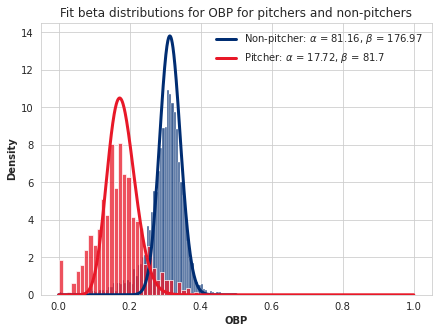

<Figure size 504x360 with 0 Axes>

In [65]:
# Plot Batting avg for all players/all years
with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()

    # Non pitcher
    sns.histplot(data=grouped.loc[(grouped.TA > 10) & (grouped.Pitcher == False),:],x="OBP",color=phillies_blue,ax=ax,stat="density")
    x = np.linspace(0,.5,1000)
    ax.plot(x,stats.beta.pdf(x,result_notpitcher["x"][0],result_notpitcher["x"][1]),color=phillies_blue,lw=3,label=r"Non-pitcher: $\alpha$ = {}, $\beta$ = {}".format(round(result_notpitcher["x"][0],2),round(result_notpitcher["x"][1],2)))
    fig = plt.figure(figsize=(7,5))
    
    # Pitcher
    sns.histplot(data=grouped.loc[(grouped.TA > 10) & (grouped.Pitcher == True),:],x="OBP",color=phillies_red,ax=ax,stat="density")
    x = np.linspace(0,1,1000)
    ax.plot(x,stats.beta.pdf(x,result_pitcher["x"][0],result_pitcher["x"][1]),color=phillies_red,lw=3,label=r"Pitcher: $\alpha$ = {}, $\beta$ = {}".format(round(result_pitcher["x"][0],2),round(result_pitcher["x"][1],2)))

    ax.legend(frameon=False)
    ax.set_xlabel("OBP",fontweight="bold")
    ax.set_ylabel("Density",fontweight="bold")

    ax.set_title("Fit beta distributions for OBP for pitchers and non-pitchers")

We can also try this with PyMC.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 83 seconds.
The acceptance probability does not match the target. It is 0.8947, but should be close to 0.8. Try to increase the number of tuning steps.


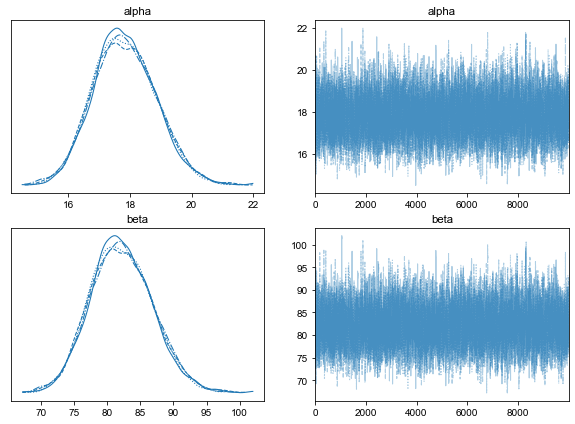

In [74]:
import pymc as pm
import arviz as az

# Instance of pymc model
with pm.Model() as model_pitcher:
    # Define alpha and beta as coming from uniform distribution
    alpha0 = pm.Uniform('alpha',10,300)
    beta0  = pm.Uniform('beta',10,400)

    # Beta-binomial distribution
    X0 = pm.BetaBinomial("X",alpha=alpha0,beta=beta0,observed=grouped.loc[(grouped.TA > min_atbat) & (grouped.Pitcher == True),'OB'].to_numpy(),n=grouped.loc[(grouped.TA > min_atbat) & (grouped.Pitcher == True),'TA'].to_numpy())

    # Inference! Perform sampling
    idata_p = pm.sample(10000)

az.plot_trace(idata_p, figsize=(10, 7))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 171 seconds.
The acceptance probability does not match the target. It is 0.8867, but should be close to 0.8. Try to increase the number of tuning steps.


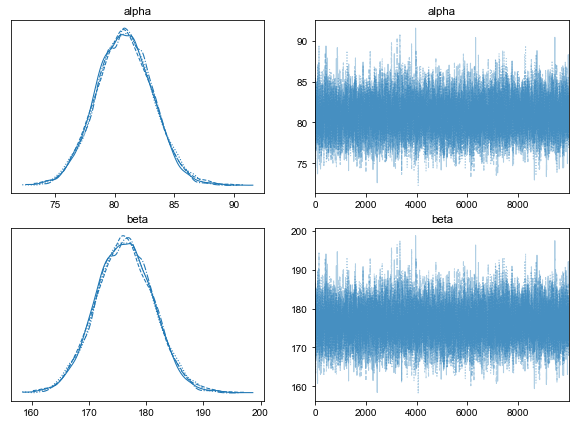

In [76]:
# Instance of pymc model
with pm.Model() as model_nonpitcher:
    # Define alpha and beta as coming from uniform distribution
    alpha0 = pm.Uniform('alpha',10,300)
    beta0  = pm.Uniform('beta',10,400)

    # Beta-binomial distribution
    X0 = pm.BetaBinomial("X",alpha=alpha0,beta=beta0,observed=grouped.loc[(grouped.TA > min_atbat) & (grouped.Pitcher == False),'OB'].to_numpy(),n=grouped.loc[(grouped.TA > min_atbat) & (grouped.Pitcher == False),'TA'].to_numpy())

    # Inference! Perform sampling
    idata_np = pm.sample(10000)

az.plot_trace(idata_np, figsize=(10, 7))

In [82]:
# Get params from pymc
alpha_pymc_p = idata_p.posterior["alpha"].mean(("chain","draw")).to_numpy().item()
beta_pymc_p  = idata_p.posterior["beta"].mean(("chain","draw")).to_numpy().item()

alpha_pymc_np = idata_np.posterior["alpha"].mean(("chain","draw")).to_numpy().item()
beta_pymc_np  = idata_np.posterior["beta"].mean(("chain","draw")).to_numpy().item()

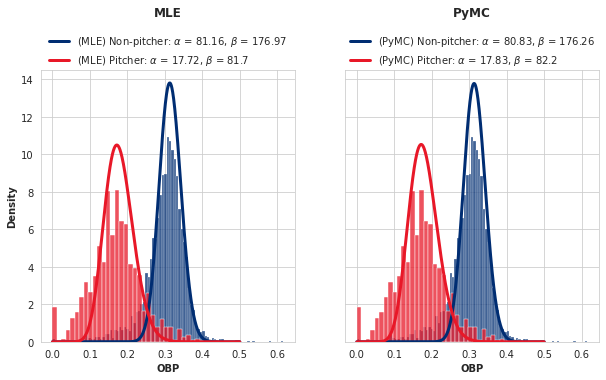

In [105]:
# Plot Batting avg for all players/all years
with sns.axes_style("whitegrid"):
    # Make figure
    fig, ax = plt.subplots(1,2,sharey=True,sharex=True)
    fig.set_size_inches(10,5)
    
    #### MLE ####

    # Non pitcher
    sns.histplot(data=grouped.loc[(grouped.TA > 10) & (grouped.Pitcher == False),:],x="OBP",color=phillies_blue,ax=ax[0],stat="density")
    x = np.linspace(0,.5,1000)
    ax[0].plot(x,stats.beta.pdf(x,result_notpitcher["x"][0],result_notpitcher["x"][1]),color=phillies_blue,lw=3,label=r"(MLE) Non-pitcher: $\alpha$ = {}, $\beta$ = {}".format(round(result_notpitcher["x"][0],2),round(result_notpitcher["x"][1],2)))
    
    # Pitcher
    sns.histplot(data=grouped.loc[(grouped.TA > 10) & (grouped.Pitcher == True),:],x="OBP",color=phillies_red,ax=ax[0],stat="density")
    ax[0].plot(x,stats.beta.pdf(x,result_pitcher["x"][0],result_pitcher["x"][1]),color=phillies_red,lw=3,label=r"(MLE) Pitcher: $\alpha$ = {}, $\beta$ = {}".format(round(result_pitcher["x"][0],2),round(result_pitcher["x"][1],2)))

    ax[0].legend(loc=9,bbox_to_anchor=(0.5,1.165),frameon=False)
    ax[0].set_xlabel("OBP",fontweight="bold")
    ax[0].set_ylabel("Density",fontweight="bold")

    ax[0].set_title("MLE",y=1.175,fontweight="bold")


    #### PYMC ####

    # Non pitcher
    sns.histplot(data=grouped.loc[(grouped.TA > 10) & (grouped.Pitcher == False),:],x="OBP",color=phillies_blue,ax=ax[1],stat="density")
    x = np.linspace(0,.5,1000)
    ax[1].plot(x,stats.beta.pdf(x,alpha_pymc_np,beta_pymc_np),color=phillies_blue,lw=3,label=r"(PyMC) Non-pitcher: $\alpha$ = {}, $\beta$ = {}".format(round(alpha_pymc_np,2),round(beta_pymc_np,2)))
    
    # Pitcher
    sns.histplot(data=grouped.loc[(grouped.TA > 10) & (grouped.Pitcher == True),:],x="OBP",color=phillies_red,ax=ax[1],stat="density")
    ax[1].plot(x,stats.beta.pdf(x,alpha_pymc_p,beta_pymc_p),color=phillies_red,lw=3,label=r"(PyMC) Pitcher: $\alpha$ = {}, $\beta$ = {}".format(round(alpha_pymc_p,2),round(beta_pymc_p,2)))

    ax[1].legend(loc=9,bbox_to_anchor=(0.5,1.165),frameon=False)
    ax[1].set_xlabel("OBP",fontweight="bold")
    ax[1].set_ylabel("Density",fontweight="bold")

    ax[1].set_title("PyMC",y=1.175,fontweight="bold")
    

    # .set_title("Fit beta distributions for OBP for pitchers and non-pitchers")

### Perform Shrinkage

In [339]:
# Compute EB estimate of OBP
def eb_estimate_obp(row):
    OB = (row.H + row.BB + row.HBP)
    TA = (row.AB + row.BB + row.HBP + row.SF)
    alpha, beta = get_params(row)
    row["OBP_EB"] = (OB + alpha) / (TA + alpha + beta)
    return row

def get_params(row):
    if row.Pitcher == True: 
        alpha, beta = alpha_pymc_p, beta_pymc_p
    else: 
        alpha, beta = alpha_pymc_np, beta_pymc_np
    return alpha, beta

def compute_alpha_beta(row):
    OB = (row.H + row.BB + row.HBP)
    TA = (row.AB + row.BB + row.HBP + row.SF)
    alpha, beta = get_params(row)
    row["alpha2018"] = (OB + alpha) 
    row["beta2018"]  = (beta + TA - OB)
    return row    

# Add estimate of OBP to dataframe
grouped = grouped.apply(lambda row: compute_alpha_beta(row),axis=1)

# Add new alpha and beta params for hits through the end of the 2018 season
grouped = grouped.apply(lambda row: eb_estimate_obp(row),axis=1)



Let's see the impact of the shrinkage.

/var/folders/mb/lkph6zw14x3fgj_tmmjpq0nr0000gn/T/ipykernel_12043/774383629.py:43: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(splot,ticks=cbar_ticks)
/var/folders/mb/lkph6zw14x3fgj_tmmjpq0nr0000gn/T/ipykernel_12043/774383629.py:43: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(splot,ticks=cbar_ticks)


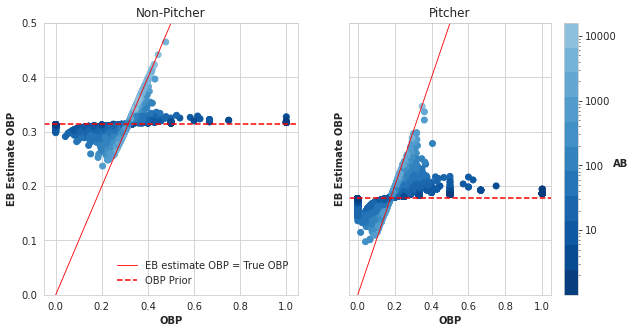

In [340]:
import matplotlib as mpl

group_by_pitcher = grouped.groupby(by="Pitcher")

with sns.axes_style("whitegrid"):
    # Make figure
    fig, ax = plt.subplots(1,2,sharey=True,sharex=True)
    fig.set_size_inches(10,5)
    # Get colormap
    cmap = mpl.cm.Blues_r(np.linspace(0,1,20))
    cmap = mpl.colors.ListedColormap(cmap[1:12])

    #### NOT PITCHER ####
    # Plot scatter 
    splot = ax[0].scatter(group_by_pitcher.get_group(False)["OBP"],group_by_pitcher.get_group(False)["OBP_EB"],c=group_by_pitcher.get_group(False)["TA"],cmap=cmap,norm=mpl.colors.LogNorm())
    # Plot x=y
    ax[0].plot(np.linspace(0,1,1000),np.linspace(0,1,1000),color='r',lw=0.85,label="EB estimate OBP = True OBP")
    # Plot pure eb estimate
    ax[0].axhline(y=(alpha_pymc_np/(alpha_pymc_np+beta_pymc_np)),color='r',linestyle='--',label="OBP Prior")
    ax[0].set_ylim(0,0.5)
    ax[0].set_yticks(np.arange(0,0.6,0.1))
    ax[0].set_xlabel("OBP",fontweight="bold")
    ax[0].set_ylabel("EB Estimate OBP",fontweight="bold")
    ax[0].legend(frameon=False)
    ax[0].set_title("Non-Pitcher")

    #### PITCHER ####
    # Plot scatter 
    splot1 = ax[1].scatter(group_by_pitcher.get_group(True)["OBP"],group_by_pitcher.get_group(True)["OBP_EB"],c=group_by_pitcher.get_group(True)["TA"],cmap=cmap,norm=mpl.colors.LogNorm())
    # Plot x=y
    ax[1].plot(np.linspace(0,1,1000),np.linspace(0,1,1000),color='r',lw=0.85,label="EB estimate OBP = True OBP")
    # Plot pure eb estimate
    ax[1].axhline(y=(alpha_pymc_p/(alpha_pymc_p+beta_pymc_p)),color='r',linestyle='--',label="OBP Prior")
    ax[1].set_ylim(0,0.5)
    ax[1].set_yticks(np.arange(0,0.6,0.1))
    ax[1].set_xlabel("OBP",fontweight="bold")
    ax[1].set_ylabel("EB Estimate OBP",fontweight="bold")
    ax[1].set_title("Pitcher")
    # ax[1].legend(frameon=False)

    # Clean up
    cbar_ticks = [0,10,100,1000,10000]
    cbar = plt.colorbar(splot,ticks=cbar_ticks)
    cbar.ax.set_yticklabels(list(map(str, cbar_ticks)))
    cbar.set_label("AB",rotation=0,fontweight="bold")
    

## EB Estimate on provided data

In [ ]:
# Load data with additional features
bd = pd.read_pickle("./data/batting_data_postML.pkl")
bd.head()

,playerid,Name,Team,MarApr_PA,MarApr_AB,MarApr_H,MarApr_HR,MarApr_R,MarApr_RBI,MarApr_SB,...,MarApr_double,MarApr_triple,MarApr_field_out,MarApr_double_play,MarApr_launch_speed,MarApr_launch_angle,MarApr_pfx_z,MarApr_pfx_x,MarApr_release_speed,MarApr_release_spin_rate
0,15998,Cody Bellinger,LAD,132,109,47,14,32,37,5,...,0.055046,0.009174,0.385321,0.018349,87.235032,18.292994,0.810637,-0.219299,88.812102,2188.322581
1,11477,Christian Yelich,MIL,124,102,36,14,26,34,6,...,0.039216,0.000000,0.441176,0.000000,89.436364,14.803030,0.860530,-0.215455,89.756818,2201.229008
2,17975,Scott Kingery,PHI,35,32,13,2,5,6,1,...,0.125000,0.000000,0.375000,0.000000,82.207317,13.707317,0.706829,-0.071463,89.407317,2283.024390
3,7927,Eric Sogard,TOR,49,43,17,3,8,9,2,...,0.093023,0.000000,0.465116,0.000000,83.076271,21.881356,0.669322,-0.305763,88.010169,2255.440678
4,14130,Daniel Vogelbach,SEA,92,71,22,8,15,16,0,...,0.084507,0.000000,0.422535,0.000000,86.067033,23.241758,0.687802,-0.388022,89.013187,2195.700000


Add fangraphs ID to our grouped dataframe.

In [341]:
def add_fangraphs_id(row,_players):
    key = _players.loc[_players.key_bbref.isin([row.playerID]),"key_fangraphs"]
    if not key.empty:
        row["key_fangraphs"] = key.item()
    else:
        row["key_fangraphs"] = "empty"
    return row
        
grouped = grouped.apply(lambda row: add_fangraphs_id(row,_players),axis=1)        

This cell takes a while to run because we have to gather data for each player every time we call the function from apply...

In [342]:
# Get all pitcher data
_pitcher = pybaseball.playerid_reverse_lookup(pitching_data.playerID.unique().tolist(),key_type='bbref')

# Get alpha, beta if pitcher or not
def get_params(row):
    if row.Pitcher == True: 
        alpha, beta = alpha_pymc_p, beta_pymc_p
    else: 
        alpha, beta = alpha_pymc_np, beta_pymc_np
    return alpha, beta

# Add data to dataframe
def add_eb_to_2019data(row,grouped):
    # Get row
    x = grouped.loc[grouped.key_fangraphs.isin([row.playerid]),:]

    # Determine if pitcher
    is_pitcher = False
    if len(_pitcher.loc[_pitcher.key_fangraphs.isin([row.playerid]),:]):
        is_pitcher = True
    row["Pitcher"] = is_pitcher
    
    # Check if row from grouped data frame is not empty
    if len(x) > 0:
        # Get alpha and beta
        row["alpha2018"] = x["alpha2018"].item()
        row["beta2018"]  = x["beta2018"].item()
    else:
        # Get alpha and beta
        alpha, beta = get_params(row)
        row["alpha2018"] = alpha
        row["beta2018"]  = beta

    # Get player data
    temp = pybaseball.statcast_batter(start_dt='2019-03-01', end_dt='2019-04-30',player_id=row.key_mlbam)
    counts = temp.events.value_counts()

    # Get values for computing OBP
    row["MarApr_BB"]  = temp.events.value_counts()["walk"].item() if "walk" in temp.events.value_counts() else 0
    row["MarApr_HBP"] = temp.events.value_counts()["hit_by_pitch"].item() if "hit_by_pitch" in temp.events.value_counts() else 0
    row["MarApr_SF"]  = temp.events.value_counts()["sac_fly"].item() if "sac_fly" in temp.events.value_counts() else 0

    # Compute new OBP
    OB = (row.MarApr_H + row.MarApr_BB + row.MarApr_HBP)
    TA = (row.MarApr_AB + row.MarApr_BB + row.MarApr_HBP + row.MarApr_SF)
    row["MarApr_OBP_EB"] = (OB + row["alpha2018"]) / (TA + row["alpha2018"] + row["beta2018"])

    return row

bd = bd.apply(lambda row: add_eb_to_2019data(row,grouped),axis=1)


Gathering Player Data


### Plot EB estimate versus measured data

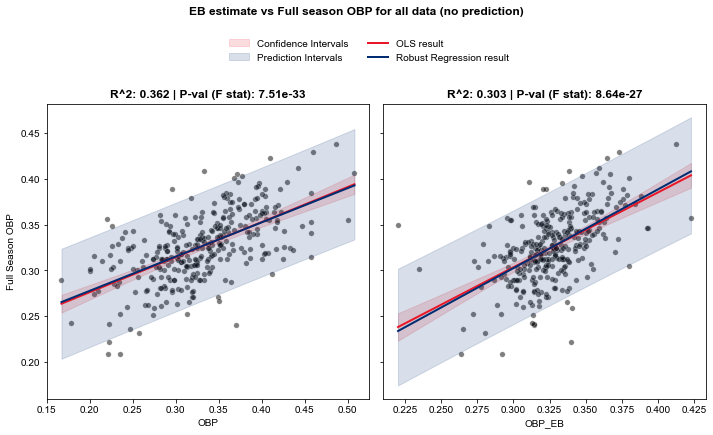

In [354]:
# OLS using statsmodels
def run_regression(xx,yy):
    X = sm.add_constant(xx)#, prepend=False)
    ols = sm.OLS(yy,X)
    ols_result = ols.fit()
    return ols_result

def robust_regression(xx,yy):
    X = sm.add_constant(xx)#, prepend=False)
    rlm = sm.RLM(yy,X)
    rlm_result = rlm.fit()
    return rlm_result


# Make figure
fig, allax = plt.subplots(1,2,sharey=True)
allax = allax.flatten()
fig.set_size_inches(10,5)

# Show data
for cnt, col in enumerate(["OBP","OBP_EB"]):
    # Plot data
    this_col = 'MarApr_' + col
    sns.scatterplot(data=bd,x=this_col,y="FullSeason_OBP",ax=allax[cnt],color='k',alpha=0.5,s=30)
    allax[cnt].set_xlabel(col)
    allax[cnt].set_ylabel("Full Season OBP")

    # Run regression
    model = run_regression(bd[this_col],bd["FullSeason_OBP"])
    xvals= np.linspace(bd[this_col].min(),bd[this_col].max(),1000)
    xvals2 = sm.add_constant(xvals)

    # Plot Confidence and Prediction intervals
    CI = model.get_prediction(xvals2).summary_frame(alpha=0.05)
    allax[cnt].fill_between(xvals,CI.mean_ci_lower.to_numpy(),CI.mean_ci_upper.to_numpy(),color=phillies_red,alpha=0.15,label="Confidence Intervals")
    allax[cnt].fill_between(xvals,CI.obs_ci_lower.to_numpy(),CI.obs_ci_upper.to_numpy(),color=phillies_blue,alpha=0.15,label="Prediction Intervals")

    # Plot regression
    allax[cnt].plot(xvals,model.predict(xvals2),color=phillies_red,lw=2,label="OLS result")
    allax[cnt].set_title("R^2: {} | P-val (F stat): {}".format(model.rsquared.round(3), format(model.f_pvalue,".2e")),fontweight="bold")

    # Run regression
    model2 = robust_regression(bd[this_col],bd["FullSeason_OBP"])
    allax[cnt].plot(xvals,model2.predict(xvals2),color=phillies_blue,lw=2,label="Robust Regression result")

plt.tight_layout()

fig.suptitle("EB estimate vs Full season OBP for all data (no prediction)",y=1.2,fontweight="bold")
allax[0].legend(loc=9,ncol=2,bbox_to_anchor=(1,1.25),frameon=False)


Sadly, the initial correlation between full season OBP and our emperical Bayes estimate of OBP doesn't seem much better than the relationship between the current actual OBP and the final OBP. Nonetheless, let's try using the new data to predict.

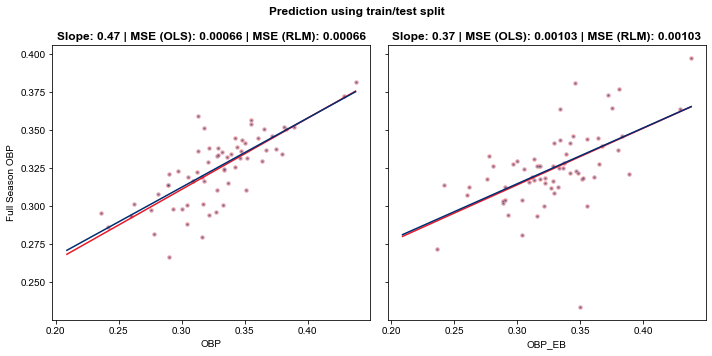

In [356]:
from sklearn.model_selection import train_test_split

# Make figure
fig, allax = plt.subplots(1,2,sharey=True)
allax = allax.flatten()
fig.set_size_inches(10,5)

# Make xdata
xout = np.linspace(bd["FullSeason_OBP"].min(),bd["FullSeason_OBP"].max(),100)
xout2 = sm.add_constant(xout)

# For each column in the data
for cnt, col in enumerate(["OBP","OBP_EB"]):
    
    # Split train/test data
    this_col = 'MarApr_' + col
    x_train, x_test, y_train, y_test = train_test_split(bd[this_col],bd["FullSeason_OBP"],test_size=0.20, random_state=4)
  
    # # Run regression
    model = run_regression(x_train,y_train)
    xvals= sm.add_constant(x_test)
    y_predict = model.predict(xvals)
    
    # Plot
    sns.scatterplot(x=y_test,y=y_predict,ax=allax[cnt],color=phillies_red,alpha=0.5,s=20)
    out = run_regression(y_test,y_predict)
    allax[cnt].plot(xout,out.predict(xout2),color=phillies_red) 

    # # Robust regression
    model2 = run_regression(x_train,y_train)
    y_predict2 = model2.predict(xvals)
    
    # Plot
    sns.scatterplot(x=y_test,y=y_predict2,ax=allax[cnt],color=phillies_blue,alpha=0.5,s=20,marker="*")
    out2 = robust_regression(y_test,y_predict2)
    allax[cnt].plot(xout,out2.predict(xout2),color=phillies_blue) 

    allax[cnt].set_title("Slope: {} | MSE (OLS): {} | MSE (RLM): {}".format(round(out.params[1],2),round(np.mean(np.square(y_predict - y_test)),5),round(np.mean(np.square(y_predict2 - y_test)),5)),fontweight="bold")
    allax[cnt].set_xlabel(col)
    allax[cnt].set_ylabel("Full Season OBP")
    # slope.append(out.params[1])

fig.suptitle("Prediction using train/test split",fontweight="bold")
plt.tight_layout()


It seems that since our EB estimate stops at the data for March and April, we are only relying on a small number of H/AB compared to the full season. This has the impact of overly *shrinking* our estimate causing it to deviate more from the final season value than if we simply used the current OBP to estimate the value. There may be some things we are not accounting for in our estimate, such as how OBP changes with number of career ABs thus far and how it changes based on the year. For the first, we see that the more ABs a person has, the more their EB estimate converges to their true estimate. For players with low ABs (or total OBP plate appearances here), the OBP can be heavily biased. We have already accounted for pitcher and non-pitchers, so lets see if either of these makes a difference. 

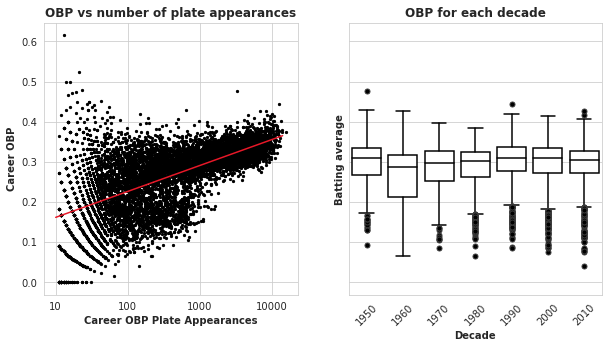

In [398]:
grouped["decade"] = (grouped.yearID//10)*10

# Make figure
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1,2,sharey=True)
    fig.set_size_inches(10,5)

    min_atbat = 10
    # Plot total appearances versus obp for career data (year <= 2018)
    ax[0].scatter(np.log10(grouped.loc[grouped.AB>min_atbat,"TA"]), grouped.loc[grouped.AB>min_atbat,"OBP"],color='k',s=5)

    # Fit data
    xvals = np.linspace(10,grouped.AB.max(),1000)
    ols_result = run_regression(np.log10(grouped.loc[grouped.AB>min_atbat,"TA"]),grouped.loc[grouped.AB>min_atbat,"OBP"])
    ax[0].plot(np.log10(xvals),np.log10(xvals)*ols_result.params[1] + ols_result.params[0],color=phillies_red)

    # Convert to log and clean up
    ax[0].set_xticks([1,2,3,4])
    ax[0].set_xticklabels(list(map(str,[10,100,1000,10000])))
    ax[0].set_ylabel("Career OBP",fontweight="bold")
    ax[0].set_xlabel("Career OBP Plate Appearances",fontweight="bold")
    ax[0].set_title("OBP vs number of plate appearances",fontweight="bold")

    # Now add boxplots showing trend over the years
    props = {'flierprops': {"markerfacecolor": 'k', "markersize": 5,
                "linestyle":'none',"marker": 'o'},
        'boxprops':{'facecolor':'w', 'edgecolor':'k'},
        'medianprops':{'color':'k'},
        'whiskerprops':{'color':'k'},
        'capprops':{'color':'k'}
    }
    # we pick TA > 100 or more here to see how this reduces noise when including players with low TAs
    sns.boxplot(ax=ax[1],data=grouped.loc[grouped.TA > 100,:],x="decade",y="OBP",**props)
    ax[1].set_xlabel("Decade",fontweight="bold")
    ax[1].set_ylabel("Batting average",fontweight="bold")
    plt.xticks(rotation = 45)
    ax[1].set_title("OBP for each decade",fontweight="bold")


Clearly the number of plate appearances is log-linearly correlated with OBP, so a better shrunken estimate would include this when generating a prior for each player. Thus for a player in 2019 with thousands of appearances, their end of year OBP would likely be similair to their end of 2018 season OBP biases slighty by the 2019 number of times on base / total appearances in 2019. For the sake of time, we will not add the number of plate appearances into our model to correct our priors, but this can easily be done but including a `log(TA)` in our MLE or PyMC model. 

### Add uncertainty (very naive approach here)

Our model above did not try to estimate future (end of 2019) number of times on-base per total 2019 plate appearances, but simply correlated the current 2019 OBP or shrunken OBP with the end of season OBP. What we really need to do is try to estimate how many times on base and total plate appearances a player will have in the future. Lets try to see how players did in 2018 but looking at their `OB/TA` during March/April and seeing how that relates to their `OB/TA` by end of season. 

In [421]:
# Add data to dataframe
def add_2018_data(row):

    # Get player data
    temp = pybaseball.statcast_batter(start_dt='2018-03-01', end_dt='2018-10-28',player_id=row.key_mlbam)

    # Get data for march/april 2018
    filt = temp.loc[(temp.game_date >= '2018-03-01') & (temp.game_date < '2018-05-01'),:].copy()
    counts = filt.events.value_counts()

    # Get values for computing OBP
    which_events = ["single","double","triple","home_run","walk","hit_by_pitch","sac_fly","field_out","strikeout","grounded_into_double_play","force_out","field_error"]
    event_names  = ["1B","2B","3B","HR","BB","HBP","SF","FieldOut","K","GIDP","ForceOut","FieldErr"]
    for (event,name) in zip(which_events,event_names):
        row["MarApr2018_" + name]  = filt.events.value_counts()[event].item() if event in filt.events.value_counts() else 0

    # Compute new OBP
    row["MarApr2018_H"]   = row.MarApr2018_1B + row.MarApr2018_2B + row.MarApr2018_3B + row.MarApr2018_HR
    row["MarApr2018_AB"]  = row.MarApr2018_H + row.MarApr2018_FieldOut + row.MarApr2018_K + row.MarApr2018_GIDP + row.MarApr2018_ForceOut + row.MarApr2018_FieldErr
    row["MarApr2018_OB"]  = (row.MarApr2018_H + row.MarApr2018_BB + row.MarApr2018_HBP)
    row["MarApr2018_TA"]  = (row.MarApr2018_AB + row.MarApr2018_BB + row.MarApr2018_HBP + row.MarApr2018_SF)
    row["MarApr2018_OBP"] = row["MarApr2018_OB"] / row["MarApr2018_TA"] if row["MarApr2018_TA"] > 0 else 0

    # Now do this for all of 2018
    for (event,name) in zip(which_events,event_names):
        row["EOS2018_" + name]  = temp.events.value_counts()[event].item() if event in temp.events.value_counts() else 0

    # Compute new OBP
    row["EOS2018_H"]   = row.EOS2018_1B + row.EOS2018_2B + row.EOS2018_3B + row.EOS2018_HR
    row["EOS2018_AB"]  = row.EOS2018_H + row.EOS2018_FieldOut + row.EOS2018_K + row.EOS2018_GIDP + row.EOS2018_ForceOut + row.EOS2018_FieldErr
    row["EOS2018_OB"]  = (row.EOS2018_H + row.EOS2018_BB + row.EOS2018_HBP)
    row["EOS2018_TA"]  = (row.EOS2018_AB + row.EOS2018_BB + row.EOS2018_HBP + row.EOS2018_SF)
    row["EOS2018_OBP"] = row["EOS2018_OB"] / row["EOS2018_TA"] if row["EOS2018_TA"] > 0 else 0

    return row

bd2018 = bd.apply(lambda row: add_2018_data(row),axis=1)


Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering 

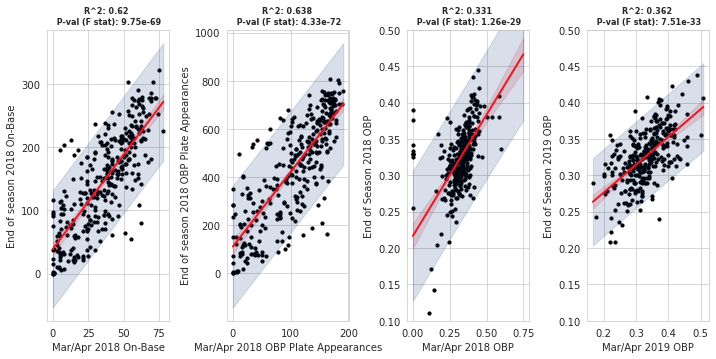

In [447]:
def plot_regression_with_CI(ax,data,X,Y):

    # Run regression
    model = run_regression(data[X],data[Y])
    xvals= np.linspace(data[X].min(),data[X].max(),1000)
    xvals2 = sm.add_constant(xvals)

    # Plot Confidence and Prediction intervals
    CI = model.get_prediction(xvals2).summary_frame(alpha=0.05)
    ax.fill_between(xvals,CI.mean_ci_lower.to_numpy(),CI.mean_ci_upper.to_numpy(),color=phillies_red,alpha=0.15,label="Confidence Intervals")
    ax.fill_between(xvals,CI.obs_ci_lower.to_numpy(),CI.obs_ci_upper.to_numpy(),color=phillies_blue,alpha=0.15,label="Prediction Intervals")

    # Plot regression
    ax.plot(xvals,model.predict(xvals2),color=phillies_red,lw=2,label="OLS result")
    ax.set_title("R^2: {} \n P-val (F stat): {}".format(model.rsquared.round(3), format(model.f_pvalue,".2e")),fontweight="bold",fontsize=8)
    
    return ax
    
# Make figure
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1,4,sharey=False)
    fig.set_size_inches(10,5)

    ax[0].scatter(bd2018.MarApr2018_OB, bd2018.EOS2018_OB,color='k',s=10)
    ax[0] = plot_regression_with_CI(ax[0],bd2018,"MarApr2018_OB","EOS2018_OB")
    ax[0].set_ylabel("End of season 2018 On-Base")
    ax[0].set_xlabel("Mar/Apr 2018 On-Base")

    ax[1].scatter(bd2018.MarApr2018_TA, bd2018.EOS2018_TA,color='k',s=10)
    ax[1] = plot_regression_with_CI(ax[1],bd2018,"MarApr2018_TA","EOS2018_TA")
    ax[1].set_ylabel("End of season 2018 OBP Plate Appearances")
    ax[1].set_xlabel("Mar/Apr 2018 OBP Plate Appearances")

    ax[2].scatter(bd2018.MarApr2018_OBP, bd2018.EOS2018_OBP,color='k',s=10)
    ax[2] = plot_regression_with_CI(ax[2],bd2018,"MarApr2018_OBP","EOS2018_OBP")
    ax[2].set_ylim(.1,0.5)
    ax[2].set_ylabel("End of Season 2018 OBP")
    ax[2].set_xlabel("Mar/Apr 2018 OBP")

    ax[3].scatter(bd2018.MarApr_OBP, bd2018.FullSeason_OBP,color='k',s=10)
    ax[3] = plot_regression_with_CI(ax[3],bd2018,"MarApr_OBP","FullSeason_OBP")
    ax[3].set_ylim(.1,0.5)
    ax[3].set_ylabel("End of Season 2019 OBP")
    ax[3].set_xlabel("Mar/Apr 2019 OBP")

    plt.tight_layout()

Lets cut each Mar/Apr 2018 value of `On-Base` and `Total Appearances` into bins. From there, we will go through each 2019 value and determine which bin it falls into for both. We can compute the standard deviation and sample from distributions centered at the mean of the bin. Using both we will make and estimate of our final 2019 OBP for a player with those `OB/TA` values.

In [521]:
# Bin data
bd2018["MarApr2018_OB_qcut"] = pd.qcut(bd2018.MarApr2018_OB,q=10)
bd2018["MarApr2018_TA_qcut"] = pd.qcut(bd2018.MarApr2018_TA,q=10)

# Get intervals - i prefer this
OB_intervals = sorted(bd2018["MarApr2018_OB_qcut"].unique().tolist())
TA_intervals = sorted(bd2018["MarApr2018_TA_qcut"].unique().tolist())

# Group by bins
groupOB = bd2018.groupby(by="MarApr2018_OB_qcut")
groupTA = bd2018.groupby(by="MarApr2018_TA_qcut")

def plot_regression_with_CI(ax,data,X,Y):

    # Run regression
    model = run_regression(data[X],data[Y])
    xvals= np.linspace(data[X].min(),data[X].max(),1000)
    xvals2 = sm.add_constant(xvals)

    # Plot Confidence and Prediction intervals
    CI = model.get_prediction(xvals2).summary_frame(alpha=0.05)
    ax.fill_between(xvals,CI.mean_ci_lower.to_numpy(),CI.mean_ci_upper.to_numpy(),color=phillies_red,alpha=0.15,label="Confidence Intervals")
    ax.fill_between(xvals,CI.obs_ci_lower.to_numpy(),CI.obs_ci_upper.to_numpy(),color=phillies_blue,alpha=0.15,label="Prediction Intervals")

    # Plot regression
    ax.plot(xvals,model.predict(xvals2),color=phillies_red,lw=2,label="OLS result")
    ax.set_title("R^2: {} \n P-val (F stat): {}".format(model.rsquared.round(3), format(model.f_pvalue,".2e")),fontweight="bold",fontsize=8)
    
# Get mean and std
OBstats = []
for name in OB_intervals:
    temp = groupOB.get_group(name)
    meanval, stdval = temp["EOS2018_OB"].mean(), temp["EOS2018_OB"].std()
    OBstats.append((meanval,stdval))

TAstats = []
for name in TA_intervals:
    temp = groupTA.get_group(name)
    meanval, stdval = temp["EOS2018_TA"].mean(), temp["EOS2018_TA"].std()
    TAstats.append((meanval,stdval))

In [538]:
def random_sample_OBP(row, OBstats, TAstats, OB_intervals ,TA_intervals, n=100):
    # Get on base and total appearances
    OB = row.MarApr_H + row.MarApr_BB + row.MarApr_HBP
    TA = row.MarApr_AB + row.MarApr_BB + row.MarApr_HBP + row.MarApr_SF
    
    # Add to dataframe since its somehow not here yet
    row["MarApr_OB"]= OB
    row["MarApr_TA"]= TA

    # Find OB and TA in interval
    idxOB = np.where([OB in val for val in OB_intervals])[0][0]
    meanOB, stdOB = OBstats[idxOB]
    idxTA = np.where([TA in val for val in TA_intervals])[0][0]
    meanTA, stdTA = TAstats[idxTA]

    ob_arr, ta_arr, obp_arr = [], [], []
    for _ in range(n):
        obtemp = np.random.uniform(low=(meanOB-abs(stdOB)), high=(meanOB + abs(stdOB)))#np.random.normal(loc=meanOB,scale=stdOB)#
        tatemp = np.random.uniform(low=(meanTA-abs(stdTA)), high=(meanTA + abs(stdTA)))#np.random.normal(loc=meanTA,scale=stdTA)#
        ob_arr.append(obtemp)
        ta_arr.append(tatemp)
        obp_arr.append(obtemp/tatemp)
    
    # Store arrays
    row["ob_arr"]  = ob_arr
    row["ta_arr"]  = ta_arr
    row["obp_arr"] = obp_arr    
    row["ob_arr_mean"]  = np.mean(ob_arr)
    row["ta_arr_mean"]  = np.mean(ta_arr)
    row["obp_arr_mean"] = np.mean(obp_arr)
    return row

bd2018v2 = bd2018.apply(lambda row: random_sample_OBP(row,OBstats, TAstats, OB_intervals ,TA_intervals),axis=1)


Now lets see what happens if we shrink the estimates using our prior from 2018. 

In [554]:
# Add data to dataframe
def eb_estimate_obp_simulated(row):
    # EB estimate
    row["FullSeason_OBP_EB"] = (row["ob_arr_mean"] + row["alpha2018"]) / (row["ta_arr_mean"] + row["alpha2018"] + row["beta2018"])
    return row

bd2018v2 = bd2018v2.apply(lambda row: eb_estimate_obp_simulated(row),axis=1)


Now lets see how good our sampled estimate of OBP is compared to our measured 2019 end of season value. 

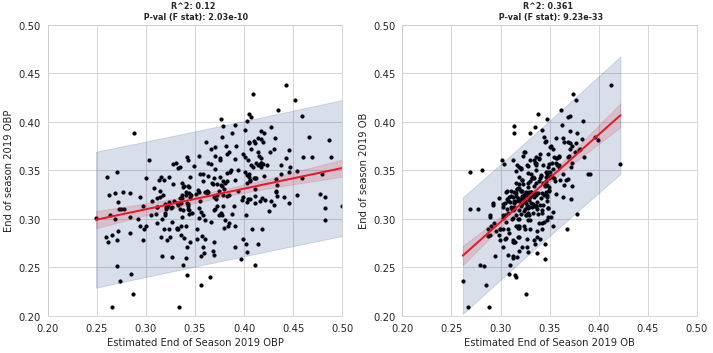

In [560]:
def plot_regression_with_CI(ax,data,X,Y):

    # Run regression
    model = run_regression(data[X],data[Y])
    xvals= np.linspace(data[X].min(),data[X].max(),1000)
    xvals2 = sm.add_constant(xvals)

    # Plot Confidence and Prediction intervals
    CI = model.get_prediction(xvals2).summary_frame(alpha=0.05)
    ax.fill_between(xvals,CI.mean_ci_lower.to_numpy(),CI.mean_ci_upper.to_numpy(),color=phillies_red,alpha=0.15,label="Confidence Intervals")
    ax.fill_between(xvals,CI.obs_ci_lower.to_numpy(),CI.obs_ci_upper.to_numpy(),color=phillies_blue,alpha=0.15,label="Prediction Intervals")

    # Plot regression
    ax.plot(xvals,model.predict(xvals2),color=phillies_red,lw=2,label="OLS result")
    ax.set_title("R^2: {} \n P-val (F stat): {}".format(model.rsquared.round(3), format(model.f_pvalue,".2e")),fontweight="bold",fontsize=8)
    
    return ax
    
# Make figure
with sns.axes_style("whitegrid"):

    fig, ax = plt.subplots(1,2,sharey=False)
    fig.set_size_inches(10,5)

    ax[0].scatter(bd2018v2.obp_arr_mean, bd2018v2.FullSeason_OBP,color='k',s=10)
    ax[0] = plot_regression_with_CI(ax[0],bd2018v2,"obp_arr_mean","FullSeason_OBP")
    ax[0].set_xlim(0.2,0.5)
    ax[0].set_ylim(0.2,0.5)
    ax[0].set_ylabel("End of season 2019 OBP")
    ax[0].set_xlabel("Estimated End of Season 2019 OBP")

    ax[1].scatter(bd2018v2.FullSeason_OBP_EB, bd2018v2.FullSeason_OBP,color='k',s=10)
    ax[1] = plot_regression_with_CI(ax[1],bd2018v2,"FullSeason_OBP_EB","FullSeason_OBP")
    ax[1].set_xlim(0.2,0.5)
    ax[1].set_ylim(0.2,0.5)
    ax[1].set_ylabel("End of season 2019 OB")
    ax[1].set_xlabel("Estimated End of Season 2019 OB")

    plt.tight_layout()

Lets see our final MSE given our real value and our shrunken estimate using simulated data:

In [562]:
np.mean(np.square(bd2018v2.FullSeason_OBP_EB - bd2018v2.FullSeason_OBP))

0.0009500663769850221

Finally, lets just see what these estimates looks like relative to the true final season OBP. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


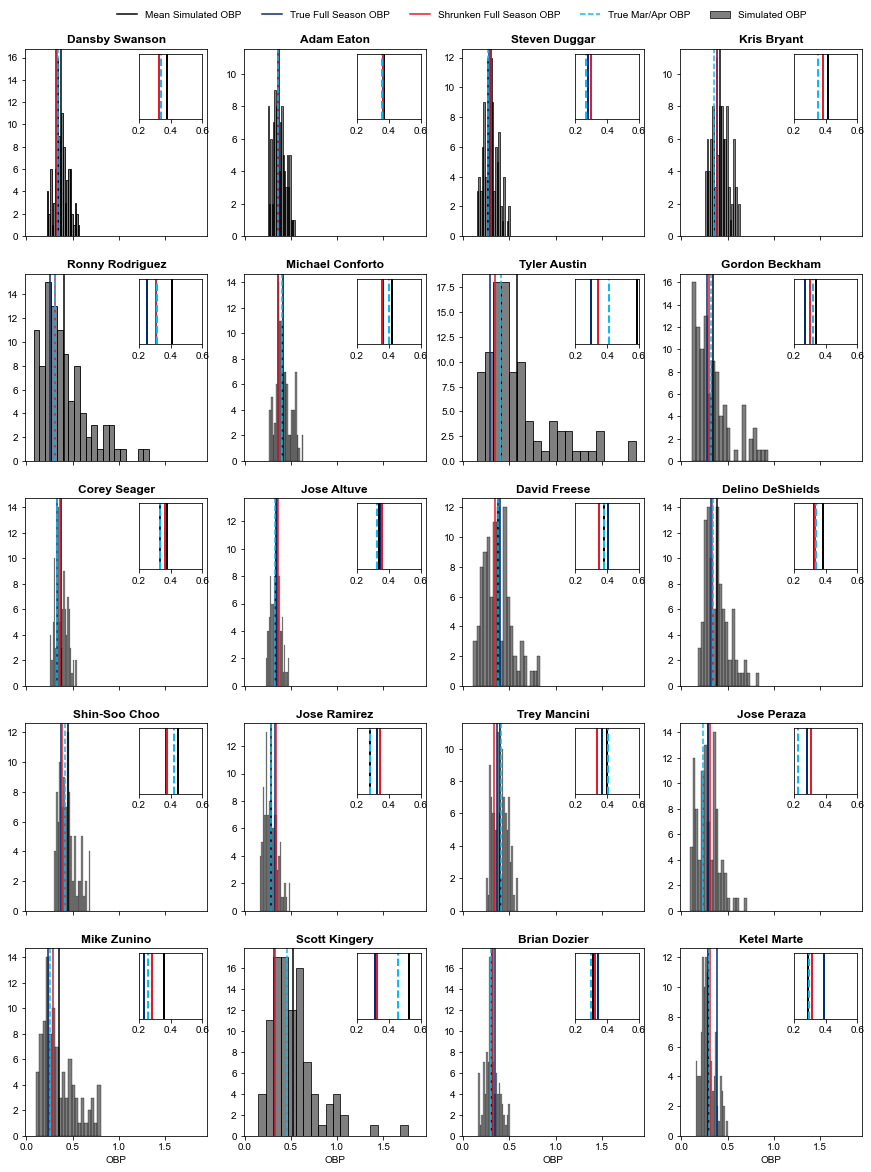

In [601]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Make figure
# with sns.axes_style("whitegrid"):
fig, ax = plt.subplots(5,4,sharex=True,sharey=False)
ax = ax.flatten()
fig.set_size_inches(15,20)

for cnt,row in enumerate(bd2018v2.sample(20).itertuples()):

    # Main axis
    sns.histplot(row.obp_arr,ax=ax[cnt],color='k',alpha=0.5,bins=20,label="Simulated OBP")
    ax[cnt].axvline(x=row.obp_arr_mean,color='k',linestyle='-',label="Mean Simulated OBP")
    ax[cnt].axvline(x=row.FullSeason_OBP,color=phillies_blue,linestyle='-',label="True Full Season OBP")
    ax[cnt].axvline(x=row.FullSeason_OBP_EB,color=phillies_red,linestyle='-',label="Shrunken Full Season OBP")
    ax[cnt].axvline(x=row.MarApr_OBP,color="deepskyblue",linestyle='--',label="True Mar/Apr OBP")
    ax[cnt].set_xlabel("OBP")
    ax[cnt].set_ylabel("")
    ax[cnt].set_title(row.Name,fontweight="bold")


    # Add inset
    axin = inset_axes(ax[cnt], width="35%", height="35%")
    axin.axvline(x=row.obp_arr_mean,color='k',linestyle='-',lw=2)
    axin.axvline(x=row.FullSeason_OBP,color=phillies_blue,linestyle='-',lw=2)
    axin.axvline(x=row.FullSeason_OBP_EB,color=phillies_red,linestyle='-',lw=2)
    axin.axvline(x=row.MarApr_OBP,color="deepskyblue",linestyle='--',lw=2)
    axin.set_xlim(0.2,0.6)
    axin.set_ylim(0,2)
    axin.set_yticks([])

    ax[2].legend(loc=9,ncol=5,frameon=False,bbox_to_anchor=(0,1.25))

It is actually interesting to see how closely the values are clustered. Some players are true to their early season numbers and the EB estimate has minimal impact on the result. On the other hand, there are some who deviate signficnatly. For example, our estimates might be signficantly biased if in 2018 they were injured, resulting in lower plate appearances than would be accurate for their other seasons. 

In [603]:
with open('./data/OBP_EB_params_pitcher.npy', 'wb') as f:
    np.save(f, (alpha_pymc_p, beta_pymc_p))

with open('./data/OBP_EB_params_nonpitcher.npy', 'wb') as f:
    np.save(f, (alpha_pymc_np, beta_pymc_np))
